## Visceral Fat Paper in SAGE

<h4>This paper was published in 2018 in the peer-reviewed medical journal, <i>Obesity</i>.</h4>
<p><b>Reference:</b> Mason A, Schleicher S, Coccia M, Epel E, <b>Aschbacher K.</b> (2018). Chronic stress and impulsive risk-taking predict increases in visceral fat over 18 months. <i>Obesity</i>, 26, 869-876. PMID: 29566458. PMCID: PMC5916011. DOI:10.1002/oby.22150.</p>
<p>The PDF can be downloaded <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/oby.22150">here:</a></p>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ka_palette as ka
from __future__ import division
import warnings

pd.set_option('display.width',500)
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
def winsorize(df, var_name, win_std):
    """win_std = Number of standard deviations below mean that determine the winsorized value.
    Currently only written for low outliers"""
    # Settings
    W_var_name = var_name + '_W'
    win_value = df[var_name].mean() - (win_std * df[var_name].std())
    n_win = (df[var_name]<win_value).sum()
    # Execute
    df[W_var_name] = df[var_name]
    df[W_var_name].loc[df[W_var_name]<win_value] = win_value
    print '\nHandling Outliers...\nFor %s: pre-winsorizing min: %d; after min: %d'%(var_name, df[var_name].min(), win_value)
    print 'Number of outliers winsorized: %d\n'%n_win

In [3]:
class Color:
    """ Class that defines colors in a palette for a bar graph. 
    I give dot_color as an argument to the class instantiation because it makes this more flexible.
    When instantiating remember to: import ka_palette as ka; t = ka.tableau(); dot_color is a string to label the color - e.g., 'red'"""
    def __init__(self, t, dot_color):
        self.dot_color = dot_color
        #self.scatter = t[dot_color]#marker color: 0=healthy/control and 1=sick/target groups     
        self.err = t['med2_grey']#error bar color
        self.edge = t['med2_grey']
        self.xlb = t['dark_grey']; self.ylb = t['dark_grey']#xlabels
        self.xtk = t['med_grey']; ytk = t['med3_grey']#xticks
        self.ytl = t['med3_grey']#yticklines
        self.leg = t['med3_grey']#legend labels
        self.box = t['med4_grey']#legend box
        self.text = t['med_grey']#p-value annotated on top of graph

In [4]:
def run_regression(x, y):
    """from __future__ import division --> needed for np.ceil math to yield a float. x and y are series"""
    reg = sm.OLS(y, sm.add_constant(x, prepend=True), missing='drop').fit()
    standB = standardize_betas(x,y,reg) 
    line_values = make_line(x, reg)
    
    return standB, reg.pvalues[1], line_values

In [5]:
def standardize_betas(x,y,reg):
    """ 
    Calculate the Standardized Coefficient = standB
    B * (Sx/Sy), where Sx = standard dev of x and Sy same w/ y
    http://www.albany.edu/faculty/kretheme/PAD705/SupportMat/StandardizedCeof.pdf
    x and y are series objects, reg is generated from sm.OLS(**kwargs).fit()"""
    B = reg.params[1]
    sx = np.std(x)#ignore intercept
    sy = np.std(y)
    standB = B*(sx/sy)#This matches SPSS perfectly
    return standB

In [6]:
def format_pvalue(p):
    # Round the p-value and add '*'
    pval = '{:.3f}'.format(p)[1:]# remove leading 0
    if p<=.001: 
        pval = u'p≤.001**'
    else: 
        pval = u'p='+pval
        # Add significance mark
        if p<=.01: pval += u'**'
        elif p<=.05: pval += u'*'
        elif p<=.10: pval += u'†'
    return pval

In [7]:
def divide_10(num, counter):
    """Recursive function determines the order of a number.  E.g., 10^2 or 10^3...
    Determines what scale/order the x-axis is on, to get right anchor points for line in the scatterplot."""
    if num>10: 
        counter += 1
        #print 'counter:%d, starting number: %d'%(counter, num)
        divide_10(num/10, counter)
    return counter

In [8]:
def make_line(x, reg):
    """Compute points to draw a fit line for the regression on top of the scatterplot. x is a series.
    For publication purposes, we sometimes need to have more specific control over this line, so 
    using a prepackaged function that makes the scatterplot and fit line together may not be ideal."""
    
    # Get min and max X values to make regression line anchors for scatterplot
    x_scale = x.max() - x.min()
    exponent = divide_10(x_scale, 0)# Always start call with 2nd argument=0
    order = np.power(10, exponent)
    
    # DEBUGGING statements
    #print 'Order: %d'%order
    #print 'min x: %d, max x: %d'%(df[x].min(), df[x].max())
    #print 'floor: %d, ceil: %d'%(np.floor((df[x].min()/order)), np.ceil((df[x].max()/order)))
    
    #A Trick which rounds up or down based on desired Order - to closest 10 or 100
    minx = order * np.floor(x.min()/order)
    maxx = order * np.ceil(x.max()/order)
    
    # Override line coordinates, so both groups are the same
    minx = -10; maxx = 20;
    
    predy = reg.predict( np.asarray([[1, minx], [1, maxx]]))#Adds intercept back
    predy = np.round(predy,decimals=3)
    #print 'min %d y %03f, and max %d y %03f \n' % (minx, predy[0], maxx, predy[1])
    
    line = np.asarray([[minx, maxx], [predy[0], predy[1]]])
    #print line# DEBUG
    return line

In [12]:
class Analysis():
    def __init__(self, df, xy_vars, xy_labels, plot_title):
        """xy_vars = list [x, y] as string names of columns in df; xy_labels as strings for printing on plot axes"""
        self.x = df[xy_vars[0]]; self.y = df[xy_vars[1]]
        self.xy_labels = xy_labels
        self.plot_title = plot_title
        self.standB, self.p, self.line = run_regression(self.x, self.y)
        self.p = format_pvalue(self.p)
        self.text = u'ß='+'{:.3f}'.format(self.standB)[1:]+', '+self.p

In [16]:
def scatterplot(analysis, c):
    """Plot a scatterplot of two groups.
    analysis is an instantiation of an Analysis class object.  c is an instantiation of a Color class object."""
    
    # Set RC-params before creating objects - changes global settings
    params = {
            'figure.figsize':(3.25, 3.5),
            'axes.facecolor':'white',
            'axes.grid':False,
            'axes.edgecolor': c.box,
            'axes.labelcolor': c.err,
            'legend.fontsize':12}
    plt.rcParams.update(params)
    
    # Plot
    fig, ax = plt.subplots()
    plt.scatter(analysis.x, analysis.y, color=c.dot_color, s=5.5)
    plt.plot(analysis.line[0], analysis.line[1], color=ka.convert_rgb('72.72.72'), lw=1)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()],visible=False)
    plt.setp([ax.get_xticklabels(), ax.get_yticklabels()],fontsize=9.5, color=c.ytl)
    plt.setp([ax.set_xlabel(analysis.xy_labels[0]),ax.set_ylabel(analysis.xy_labels[1])],fontsize=12,color=c.xlb)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    plt.title(analysis.plot_title, fontsize=13)
    
    # Force boundaries of xlim to match line
    plt.xlim(analysis.line[0][0], analysis.line[0][1])
    plt.ylim(-2,2)
    
    # Add p-values as a text annotation
    x_loc = analysis.line[0][0] + (.55 * (analysis.line[0][1] - analysis.line[0][0]))-2#determines proportion of distance along the xaxis that text appears
    #y_loc = min(analysis.y)
    y_loc = -1.79# Hack to make both the same
    ax.text(x_loc, y_loc, analysis.text, fontsize=10, color=c.text, style='italic')
    
    return fig

['FILTER_ADJUSTED_BLplus18mo', 'CH_viscan_visceral_fat_BL_to_18', 'group', 'BART_PumpsMean_BL_C', 'BART_pumpsmean_BL_GROUP_C', 'calc_age_BL', 'graduate_edu', 'white', 'meds_AD_BL', 'meds_AD_18mo', 'total_METS_sum_bl', 'total_METS_sum_18mo', 'tan_BMI_BL', 'tan_BMI_18mo', 'quest_Glucose_BL', 'quest_Glucose_18mo', 'metabolic_insulin_BL', 'metabolic_insulin_18mo']
Rows 113, Columns 18

Handling Outliers...
For CH_viscan_visceral_fat_BL_to_18: pre-winsorizing min: -2; after min: -1
Number of outliers winsorized: 5

Saved ./figures/SAGE_scatter_Controls_2018-01-31_BART_PumpsMean_BL_C_CH_viscan_visceral_fat_BL_to_18.pdf
Saved ./figures/SAGE_scatter_Caregivers_2018-01-31_BART_PumpsMean_BL_C_CH_viscan_visceral_fat_BL_to_18.pdf


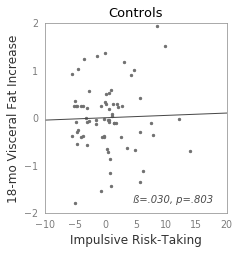

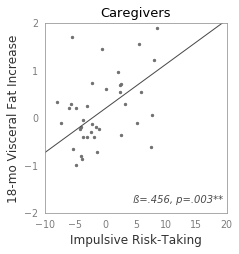

In [17]:
def main():
    
    csvfile = 'python_viscfat_20170411.csv'
    df = pd.read_csv(csvfile)
    print df.columns.tolist()
    
    
    # Limit to filtered cases
    df = df.loc[df['FILTER_ADJUSTED_BLplus18mo']==1]
    print 'Rows %d, Columns %d'%df.shape
    
    # Convert Types
    cols = ['BART_PumpsMean_BL_C','CH_viscan_visceral_fat_BL_to_18']
    for col in cols:
        df[col] = df[col].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    #print df.dtypes
    winsorize(df, 'CH_viscan_visceral_fat_BL_to_18', 1.75)
    
    # Specify graph parameters
    graphs = {'BART_VisFat':
                  {'x':cols[0],'y':cols[1],
                   'xlabel':'Impulsive Risk-Taking', 'ylabel':'18-mo Visceral Fat Increase'},
#               'BART_VisFat_Win':
#                   {'x':cols[0],'y':cols[1]+'_W',
#                    'xlabel':'BART', 'ylabel':'18-month Increase in Visceral Fat'}
              }
    
    # Loop through, plot & save scatterplot graphs   
    grp = 'group'
    plot_titles = ['Controls', 'Caregivers']
    #dot_colors = [ka.convert_rgb('8.55.106'), ka.convert_rgb('217.50.23')]#bright_navy_blue; red_orange
    dot_colors = [ka.convert_rgb('112.112.112'), ka.convert_rgb('112.112.112')]#bright_navy_blue; red_orange
    
    for data_dict in graphs.itervalues():
        for g in [0,1]:
            analysis = Analysis(df.loc[df[grp]==g], [data_dict['x'], data_dict['y']], [data_dict['xlabel'], data_dict['ylabel']], plot_titles[g])
            color = Color(ka.tableau(), dot_colors[g])#This could use optimization
            fig = scatterplot(analysis, color)
            fig_filename = './figures/SAGE_scatter_'+plot_titles[g]+'_'+str(dt.date.today())+'_'+data_dict['x']+'_'+data_dict['y']+'.pdf'
            fig.savefig(fig_filename, bbox_inches='tight', dpi=600)#transparent='False'
            print 'Saved %s'%fig_filename
    

if __name__=="__main__":
    main()